## Daily emailed weather forecasts

Like many others, my brain does not function well in the morning pre-coffee and so living in NYC with its tempermental weather I would inevitably get caught out either by rain or a sharp temperature drop. I could check the weather every morning but who remembers to do that? Instead I tried to find a way to insert a weather forecast into my normal routine in a way I couldn't miss. I thought about my morning routine and decided on two ways that I could inject a forecast without having to change my behaviour.  

1. Set up a daily email that includes both a easy to understand subject, and a quick reference chart. If you set your own email as a VIP email address in your iPhone mail app, this will mean that the subject will show as a lock screen notification, giving you a weather forecast if you even glance at the front of your phone. I often check the time on my phone in the morning, so I'll see the forecast immediately. 

2. In the time window during which I'm preparing to leave the house (7:45-8:15am), use color changing light bulbs to change the color of my living room lights to blue if it will rain, meaning I can't miss a warning to pick up my umbrella. 

This notebook will walk you through how to set up the first. The second is covered in the forecast_lights notebook. 

In [1]:
import requests
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from creds import cdict
from python_fun.core.utilities import summarize_dict

## Note I have a creds module in my pythonpath where I store any 
## sensitive information that can't be added to this repository, 
## it just takes the form of a single dictionary cdict

In [2]:
%matplotlib inline

#### Exploring the forecast.io API and using it to generate a daily personal email

For most any api call, I often write a wrapper to handle authentication and remembering endpoints and the query structure, so I can interact with it in a simpler way. 

In [3]:
def get_raw_weather(lat='40.674766',lon='-73.978959'):
    '''Simple requests wrapper to allow retrival of the latest weather forecast from the forecast.io API'''
    data = requests.get(f"https://api.forecast.io/forecast/{cdict['forecastio_api_key']}/{lat},{lon}").json()
    return data

In [4]:
raw_data = get_raw_weather()

Let's have a quick look at the data we get back from this API call, for more details see https://darksky.net/dev/docs . Here I'll use a simple utility function I wrote to pretty print nested dicts, this is particularly useful when dealing with the kind of nested data often seen in a json payload. 

In [5]:
summarize_dict(raw_data, max_expand=10, max_depth=3)

    Initial Object: <class 'dict'> with 9 elements
        latitude: 40.674766
        longitude: -73.978959
        timezone: America/New_York
        currently: <class 'dict'> with 19 elements
        minutely: <class 'dict'> with 3 elements
            summary: Clear for the hour.
            icon: clear-day
            data: <class 'list'> with 61 elements
        hourly: <class 'dict'> with 3 elements
            summary: Mostly cloudy starting tonight, continuing until tomorrow morning.
            icon: partly-cloudy-night
            data: <class 'list'> with 49 elements
        daily: <class 'dict'> with 3 elements
            summary: Mixed precipitation today through Friday, with temperatures peaking at 47°F on Tuesday.
            icon: snow
            data: <class 'list'> with 8 elements
                : <class 'dict'> with 40 elements
                : <class 'dict'> with 40 elements
                : <class 'dict'> with 39 elements
                : <class 'dict'> with

This basically consists of some metadata about the call we made (lat, lon, timezone), the forecasts at various time resolutions (currently, minutely, hourly and daily), some alerts and flags that apply to the data and a deprectated offset, that should be ignored and you should use timezone instead. 

For our purposes we will be focusing on the hourly forecast, so let's extract that and clean it up a bit

In [6]:
hourly_df = pd.DataFrame.from_dict(raw_data['hourly']['data'])
hourly_df.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
0,34.13,0.11,25.65,0.59,rain,330.84,NaN,0.0285,0.66,rain,1012.85,Light Rain,38.54,1512932400,1,10,268,11.72,5.83
1,33.28,0.22,26.12,0.61,clear-day,329.77,NaN,0.0032,0.56,rain,1013.49,Clear,38.21,1512936000,1,10,249,13.86,6.52
2,31.08,0.30,26.91,0.66,partly-cloudy-day,329.22,NaN,0.0121,0.32,rain,1014.25,Partly Cloudy,37.20,1512939600,0,10,238,18.40,8.18
3,28.69,0.24,27.55,0.71,clear-night,329.61,NaN,0.0045,0.11,rain,1014.63,Clear,36.07,1512943200,0,10,243,20.93,10.20
4,27.07,0.14,27.40,0.73,clear-night,330.45,NaN,0.0001,0.02,rain,1015.05,Clear,35.10,1512946800,0,10,243,22.98,11.07


Wonderful we now have a pandas dataframe containing a row of weather forecast per hour. Our only problem is the time column is stored in UNIX/POSIX time, but thankfully the built in datetime library can fix that pretty quick for us:


In [7]:
hourly_df.time = hourly_df.time.apply(datetime.datetime.fromtimestamp)
hourly_df.set_index('time',inplace=True)
print(f'We have {len(hourly_df)} rows of weather data')
hourly_df.head()

We have 49 rows of weather data


,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,uvIndex,visibility,windBearing,windGust,windSpeed
time,,,,,,,,,,,,,,,,,,
2017-12-10 14:00:00,34.13,0.11,25.65,0.59,rain,330.84,NaN,0.0285,0.66,rain,1012.85,Light Rain,38.54,1,10,268,11.72,5.83
2017-12-10 15:00:00,33.28,0.22,26.12,0.61,clear-day,329.77,NaN,0.0032,0.56,rain,1013.49,Clear,38.21,1,10,249,13.86,6.52
2017-12-10 16:00:00,31.08,0.30,26.91,0.66,partly-cloudy-day,329.22,NaN,0.0121,0.32,rain,1014.25,Partly Cloudy,37.20,0,10,238,18.40,8.18
2017-12-10 17:00:00,28.69,0.24,27.55,0.71,clear-night,329.61,NaN,0.0045,0.11,rain,1014.63,Clear,36.07,0,10,243,20.93,10.20
2017-12-10 18:00:00,27.07,0.14,27.40,0.73,clear-night,330.45,NaN,0.0001,0.02,rain,1015.05,Clear,35.10,0,10,243,22.98,11.07


Now we can see that we have hourly forecasts for the next two days starting with the current hour. But while dataframes are great for mainpulating data, its always easier to understand if you plot it. 

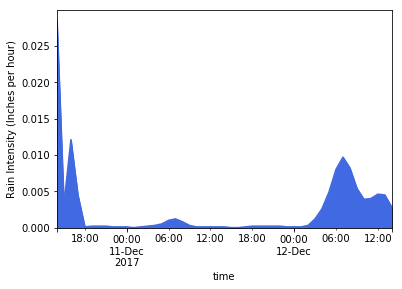

In [8]:
ax = hourly_df.precipIntensity.plot('area', style='royalblue')
ax.set_ylabel('Rain Intensity (Inches per hour)')
ax = _

Rain Intensity is interesting but since we also have Rain Probability we can make a slightly better measure of rain, the expected number of inches, which I define as the intensity of the rain * the probability of rain. In other words I consider a high chance of light rain to give the same amount of rain as a low chance of heavy rain, your mileage may vary. 

In [9]:
hourly_df['expected_precip'] = hourly_df.precipIntensity*hourly_df.precipProbability

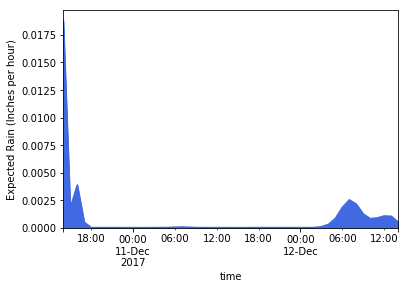

In [10]:
ax = hourly_df.expected_precip.plot('area', style='royalblue')
ax.set_ylabel('Expected Rain (Inches per hour)')
ax = _

Depending on when you run this notebook, you may or may not see some rain forecast. Let's look at temperature, regardless of when you run this notebook, you should have a temperature forecast, unless (a) the universe is about to end and this API knows that, or (b) the API is broken. 

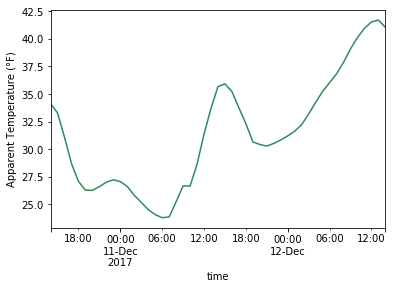

In [11]:
ax = hourly_df.apparentTemperature.plot(style='seagreen')
ax.set_ylabel('Apparent Temperature (°F)')
ax = _

Inches of rain is great if you are a meteorologist, but for everyone else, I'll replace those with some simpler indicators of light, medium, and heavy rain. The scale of your rain graph will change a lot here. Let's also put everything on one graph, that we can save/email later. 

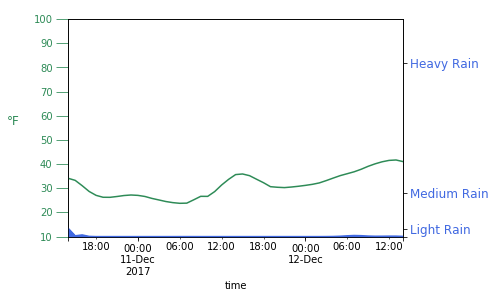

In [12]:
def make_weather_plot(df):
    fig, ax = plt.subplots()
    rain_color = 'royalblue'
    temp_color = 'seagreen'
    size=12
    df.apparentTemperature.plot(fig=fig, style=temp_color, label='°F', zorder=10)
    ax2 = df.expected_precip.plot('area', secondary_y=True, zorder=1, style=rain_color, fig=fig, sharex=True, label='Rain')
    ax.set_ylim([10, 100])
    ax.tick_params(axis='y', colors=temp_color,size=size)
    ax.set_ylabel('°F',rotation=0,labelpad=20,color=temp_color,size=size)
    ax2.set_ylim([0.0, 0.5])
    rain_ticks = [0.0,0.017,0.1,0.4]
    rain_ticknames = ['','Light Rain','Medium Rain','Heavy Rain']
    ax2.yaxis.set_ticks(rain_ticks)
    ax2.yaxis.set_ticklabels(rain_ticknames, color = rain_color, size=size)
    return fig, ax
make_weather_plot(hourly_df);

Now I don't know about you but when I'm planning my day I don't really care about rainfall or even temperature during the night, so let's define of a time period of interest. First let's assume if you are running this before 8am you want a forecast for today but if you are running it afterwards you want tomorrow's forecast (i.e. you've already left the house)

In [13]:
now = datetime.datetime.now()
if now.hour < 8:
     day_of_interest =  now.date().strftime('%Y-%m-%d')
else:
     day_of_interest =  (now.date() + datetime.timedelta(1)).strftime('%Y-%m-%d')
day_of_interest

'2017-12-11'

With that day we can now take a slice of our original dataframe looking at just a time window during which we are likely to be out and about. Now we see why we set the time to be the index of the dataframe; Pandas lets you do quite nice time slicing with a datetime index.

In [14]:
slice_of_interest = hourly_df[day_of_interest+' 08:00:00':day_of_interest+' 22:00:00']
slice_of_interest.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,expected_precip
time,,,,,,,,,,,,,,,,,,,
2017-12-11 08:00:00,25.23,0.75,26.10,0.77,partly-cloudy-day,335.68,0.006,0.0008,0.04,snow,1015.80,Mostly Cloudy,32.34,0,10,222,19.96,8.05,0.000032
2017-12-11 09:00:00,26.67,0.40,25.95,0.74,partly-cloudy-day,328.25,0.000,0.0003,0.03,snow,1016.32,Partly Cloudy,33.30,1,10,304,19.50,7.62,0.000009
2017-12-11 10:00:00,26.65,0.14,26.01,0.71,clear-day,322.51,0.000,0.0001,0.02,snow,1016.69,Clear,34.36,1,10,268,18.59,10.01,0.000002
2017-12-11 11:00:00,28.63,0.08,26.21,0.68,clear-day,320.54,NaN,0.0001,0.02,rain,1016.67,Clear,35.73,1,10,266,16.57,9.43,0.000002
2017-12-11 12:00:00,31.37,0.06,26.52,0.64,clear-day,320.28,NaN,0.0001,0.02,rain,1016.46,Clear,37.58,2,10,267,14.03,8.52,0.000002


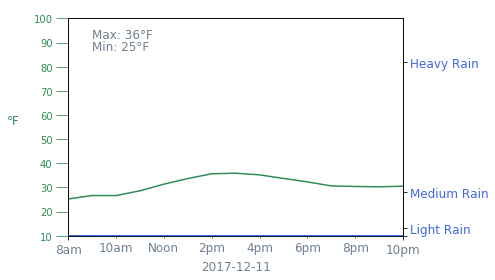

In [15]:
fig, ax = make_weather_plot(slice_of_interest)
## Let's add a little extra to the plot, now the timespan is consistent
plain_color = 'slategrey'
size=12
ax.set_xlabel(day_of_interest, size=size, color=plain_color)
ax.xaxis.set_ticklabels(['','10am','Noon','2pm','4pm','6pm','8pm',''], size=size, color=plain_color, minor=True)
ax.xaxis.set_ticklabels(['8am','10pm'], color=plain_color, size=size)
ax.annotate('Max: {:.0f}°F'.format(slice_of_interest.apparentTemperature.max()),xy=(day_of_interest+' 09:00:00', 92), color=plain_color, size=size)
ax.annotate('Min: {:.0f}°F'.format(slice_of_interest.apparentTemperature.min()),xy=(day_of_interest+' 09:00:00', 87), color=plain_color, size=size)
ax = _

Ok with our graph and sliced dataframe in hand we are almost ready to email ourselves a daily forecast. To take advantage of iPhone's previewing a VIP email's subject, let's make an email subject that is short and easy to understand at a glance. 

#### Warning I run hot, and have a tolerance for drizzle, you will want to tinker with these thresholds to suit your taste. My advice is trust your forecast and if you feel chilly or wet at the end of the day change them. 

In [16]:
coat = "No Coat" if slice_of_interest.apparentTemperature.min() > 53 else "Yes Coat"
umbrella = "No Umbrella" if slice_of_interest.expected_precip.max() < 0.005 else "Yes Umbrella"
subject = coat+", "+umbrella
print(subject)

Yes Coat, No Umbrella


With all of that in hand let's send an email with that subject and our graph in the body of the email, in case we want more details about when the rain is coming. 

In [17]:
import smtplib
from os.path import basename
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.utils import formatdate

In [18]:
# Save your figure as a file
filename = 'forecast.png'
fig.savefig(filename, bbox_inches='tight', pad_inches=0.1)

In [19]:
# Set up your email
msg = MIMEMultipart(
    From=cdict["emailuser"],
    To=cdict["emailuser"],
    Date=formatdate(localtime=True),
    Subject=subject
    )
msg['Subject'] = subject

# Attach your plot and have it display, I modifid the code from this Stack Overflow answer, there may be a better way. https://stackoverflow.com/questions/3362600/how-to-send-email-attachments
my_html = '''
<img src="{}" />
'''.format(filename)
msg.attach(MIMEText(my_html,'html'))

with open(filename, "rb") as fil:
    msg.attach(MIMEApplication(
        fil.read(),
        Content_Disposition='attachment; filename="{}"'.format(basename(filename)),
        Name=basename(filename)
    ))

# Send your email via gmail, if you use another email service, google how to setup your SMTP connection 
server = smtplib.SMTP("smtp.gmail.com:587")
server.starttls()
server.login(cdict["emailuser"], cdict["emailpass"])
server.sendmail(cdict["emailuser"], cdict["emailuser"], msg.as_string())
server.quit()

(221, b'2.0.0 closing connection y124sm3089572qkd.82 - gsmtp')

And there you go, you've now sent yourself an email with a forecast for the day and a simple subject so you know at a glance whether to grab your coat and/or umbrella. The final step is to save the above code to a script and set a cronjob to run early in the morning before you wake up, so it's waiting when you first grab your phone. Personally I have this and other daily cronjobs running on a Raspberry Pi, that I don't mind leaving on 24/7.